In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import requests
from config import rapid_api_key, gkey
import gmaps
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format

In [2]:
historical_stock_prices = pd.read_csv('daily-historical-stock-prices-1970-2018/historical_stock_prices.csv')

In [3]:
historical_stocks = pd.read_csv('daily-historical-stock-prices-1970-2018/historical_stocks.csv')

In [4]:
historical_stock_prices.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.49,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.47,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.51,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.54,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.46,11.50,11.60,184100,2013-05-14


In [5]:
combined_stocks_df = pd.merge(historical_stock_prices, historical_stocks, on='ticker', how='inner')
currently_trading_ticker = combined_stocks_df.loc[combined_stocks_df['date'] == '2018-08-24']['ticker'].values
currently_trading_df = combined_stocks_df[combined_stocks_df['ticker'].isin(currently_trading_ticker)]
cleaned_currently_trading_df = currently_trading_df.dropna(axis=0)
sorted_current_trading = cleaned_currently_trading_df.sort_values(['date','ticker'])
sorted_current_trading = sorted_current_trading.reset_index()
sorted_current_trading.head()

,index,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,14218004,AA,7.14,7.14,1.99,7.14,7.23,22500,1970-01-02,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
1,9736426,AEP,30.12,30.62,0.98,30.12,31.00,10300,1970-01-02,NYSE,"AMERICAN ELECTRIC POWER COMPANY, INC.",PUBLIC UTILITIES,ELECTRIC UTILITIES: CENTRAL
2,15855608,ARNC,6.70,6.70,1.85,6.70,6.77,24100,1970-01-02,NYSE,ARCONIC INC.,CAPITAL GOODS,METAL FABRICATIONS
3,15427303,BA,0.93,0.98,0.23,0.93,0.98,634400,1970-01-02,NYSE,BOEING COMPANY (THE),CAPITAL GOODS,AEROSPACE
4,12465494,CAT,3.54,3.46,0.38,3.45,3.54,276000,1970-01-02,NYSE,"CATERPILLAR, INC.",CAPITAL GOODS,CONSTRUCTION/AG EQUIPMENT/TRUCKS


In [6]:
#Drop rows prior to year 2000
df_cleaned_2000 = sorted_current_trading.drop(sorted_current_trading.index[:4649822])
df_cleaned_2000 = df_cleaned_2000.reset_index()
del df_cleaned_2000['index']
df_cleaned_2000.head()

,level_0,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,4649822,A,56.33,51.50,44.99,48.19,56.46,4674300,2000-01-03,NYSE,"AGILENT TECHNOLOGIES, INC.",CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS
1,4649823,AA,99.72,96.84,71.92,96.41,100.16,1291300,2000-01-03,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
2,4649824,AABA,110.73,118.75,118.75,107.38,119.25,38469600,2000-01-03,NASDAQ,ALTABA INC.,TECHNOLOGY,EDP SERVICES
3,4649825,AAME,2.38,2.31,2.15,2.25,2.44,5100,2000-01-03,NASDAQ,ATLANTIC AMERICAN CORPORATION,FINANCE,LIFE INSURANCE
4,4649826,AAN,5.37,5.22,4.54,5.22,5.37,20800,2000-01-03,NYSE,"AARON&#39;S, INC.",TECHNOLOGY,DIVERSIFIED COMMERCIAL SERVICES


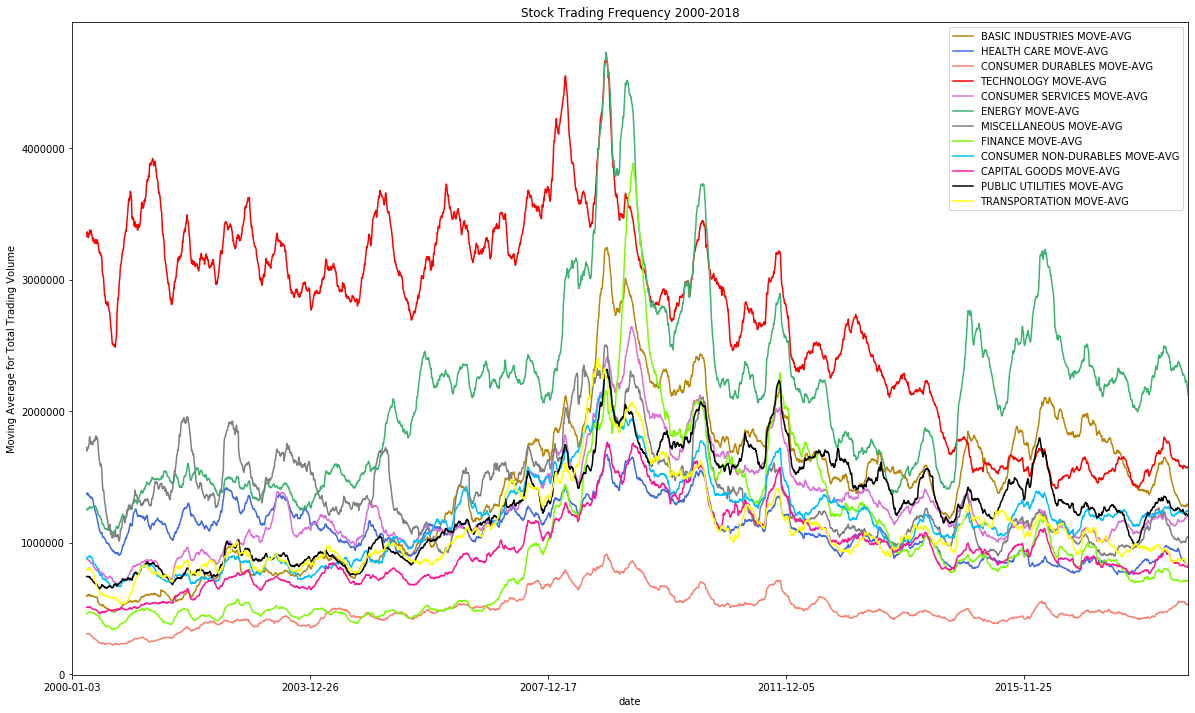

In [7]:
# Group by Sector, Date, calculate volume mean
sector_group = df_cleaned_2000.groupby(['sector','date'])
volume_mean = sector_group['volume'].mean()
sector_volume_mean = pd.DataFrame(volume_mean)
sector_volume_mean = sector_volume_mean.reset_index()
pd.options.display.float_format = "{:.2f}".format

# Pivot dataframe to view moving average of volume over 2 months
sector_volume_mean_pivot=sector_volume_mean.pivot(index='date',columns='sector')["volume"]
sector_volume_mean_pivot['BASIC INDUSTRIES MOVE-AVG'] = sector_volume_mean_pivot['BASIC INDUSTRIES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['HEALTH CARE MOVE-AVG'] = sector_volume_mean_pivot['HEALTH CARE'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CONSUMER DURABLES MOVE-AVG'] = sector_volume_mean_pivot['CONSUMER DURABLES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['TECHNOLOGY MOVE-AVG'] = sector_volume_mean_pivot['TECHNOLOGY'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CONSUMER SERVICES MOVE-AVG'] = sector_volume_mean_pivot['CONSUMER SERVICES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['ENERGY MOVE-AVG'] = sector_volume_mean_pivot['ENERGY'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['MISCELLANEOUS MOVE-AVG'] = sector_volume_mean_pivot['MISCELLANEOUS'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['FINANCE MOVE-AVG'] = sector_volume_mean_pivot['FINANCE'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CONSUMER NON-DURABLES MOVE-AVG'] = sector_volume_mean_pivot['CONSUMER NON-DURABLES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CAPITAL GOODS MOVE-AVG'] = sector_volume_mean_pivot['CAPITAL GOODS'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['PUBLIC UTILITIES MOVE-AVG'] = sector_volume_mean_pivot['PUBLIC UTILITIES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['TRANSPORTATION MOVE-AVG'] = sector_volume_mean_pivot['TRANSPORTATION'].rolling(window=63,center=False).mean()
sector_volume_moving_mean_pivot=sector_volume_mean_pivot.iloc[:, 12:]

# Chart the moving averages for volume per sector
avg_basic_industries_chart=sector_volume_moving_mean_pivot['BASIC INDUSTRIES MOVE-AVG'].plot(kind="line",figsize=(20,12),title="Stock Trading Frequency 2000-2018",color="darkgoldenrod")
avg_health_care_chart=sector_volume_moving_mean_pivot['HEALTH CARE MOVE-AVG'].plot(kind="line",color='royalblue').set_ylabel("Moving Average for Total Trading Volume",color="black")
avg_consumer_durables_chart=sector_volume_moving_mean_pivot['CONSUMER DURABLES MOVE-AVG'].plot(kind="line",color="salmon")
avg_technology_chart=sector_volume_moving_mean_pivot['TECHNOLOGY MOVE-AVG'].plot(kind="line",color="red")
avg_consumer_services_chart=sector_volume_moving_mean_pivot['CONSUMER SERVICES MOVE-AVG'].plot(kind="line",color="orchid")
avg_energy_chart=sector_volume_moving_mean_pivot['ENERGY MOVE-AVG'].plot(kind="line",color="mediumseagreen")
avg_miscellaneous_chart=sector_volume_moving_mean_pivot['MISCELLANEOUS MOVE-AVG'].plot(kind="line",color="gray")
avg_finance_chart=sector_volume_moving_mean_pivot['FINANCE MOVE-AVG'].plot(kind="line",color="lawngreen")
avg_consumer_non_durables_chart=sector_volume_moving_mean_pivot['CONSUMER NON-DURABLES MOVE-AVG'].plot(kind="line",color="deepskyblue")
avg_capital_goods_chart=sector_volume_moving_mean_pivot['CAPITAL GOODS MOVE-AVG'].plot(kind="line",color="deeppink")
avg_public_utilities_chart=sector_volume_moving_mean_pivot['PUBLIC UTILITIES MOVE-AVG'].plot(kind="line",color="black")
avg_transportation_chart=sector_volume_moving_mean_pivot['TRANSPORTATION MOVE-AVG'].plot(kind="line",color="yellow")
avg_energy_chart.legend() 
plt.savefig("General Stock Trading Frequency 2000-2018")


#The trading frequency of consumer_durable is very stable, which the trading frequency of technology,finance,energy. Thus we want to 
#investigate the return for those specific industry.


#Next we are trying to figure out the 5 year, 10 year, 15 year return.

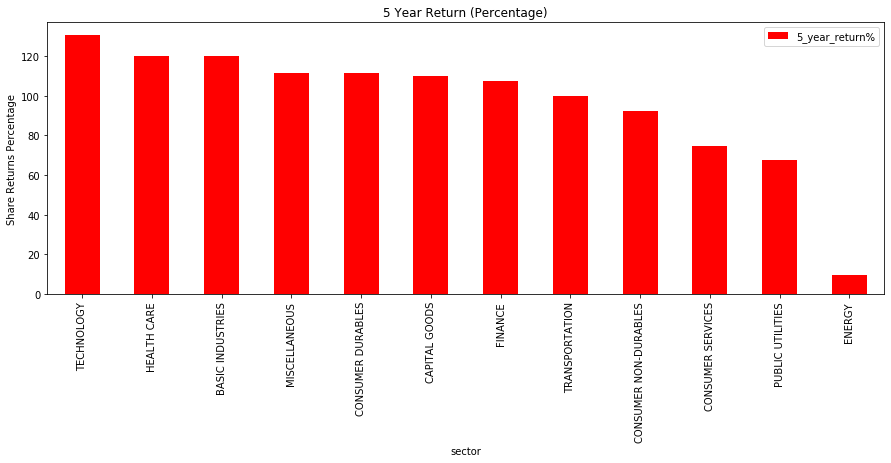

In [8]:
# 5 year return 
sector_ticker_price = df_cleaned_2000[['date', 'ticker', 'close', 'name', 'sector']]
sector_ticker_price = sector_ticker_price.set_index('ticker')
sector_ticker_price['2013_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2013-01-04']['close']
sector_ticker_price['2018_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close']
sector_ticker_price['5_year_return%'] = (sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close'] - sector_ticker_price.loc[sector_ticker_price['date'] == '2013-01-04']['close'])/sector_ticker_price.loc[sector_ticker_price['date'] == '2013-01-04']['close']*100
sector_ticker_price_five = sector_ticker_price[['name', 'sector', '5_year_return%']]
five_year_groupby_sector=sector_ticker_price_five.groupby("sector")
five_year_avg_change_by_sector=five_year_groupby_sector.mean()
five_year_avg_change_by_sector.round(2)
five_year_avg_change_by_sector = five_year_avg_change_by_sector.sort_values('5_year_return%',ascending=False)
five_year_plot=five_year_avg_change_by_sector.plot.bar(y="5_year_return%",color="r",title="5 Year Return (Percentage)",figsize=[15,5])
plt.ylabel('Share Returns Percentage')
plt.savefig("Five_year_return%")

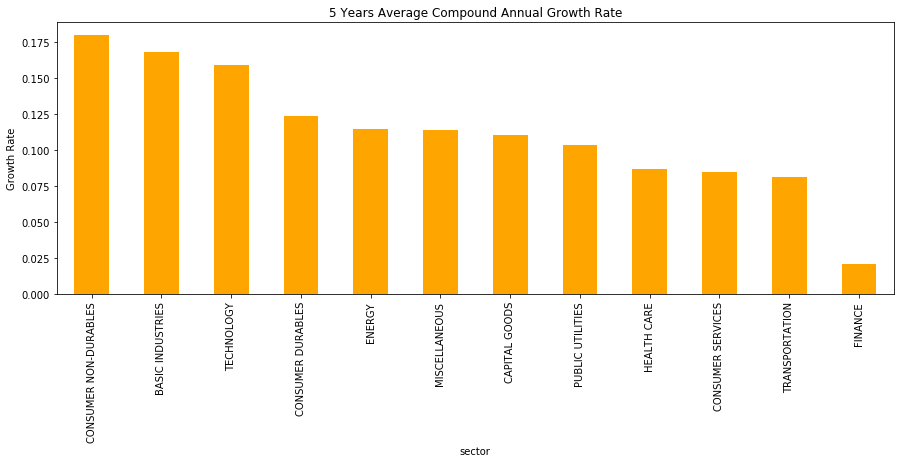

In [9]:
# 5 year Compound Annual Growth Rate
price_only=df_cleaned_2000.loc[:,['ticker','name','open','close','sector','date']]
price_only['change']=price_only['open']-price_only['close']
price_only['change percentage']=price_only['change']/price_only['open']
price_only=price_only[['ticker','open','close','change percentage','date','change','name','sector']]
price_only=price_only.set_index('ticker')

start_date = '2003-08-25'
end_dates = ['2004-08-24', '2008-08-25', '2013-08-26', '2018-08-24']
num_years = [1, 5, 10, 15]
all_stock_prices = price_only.loc[price_only['date']==start_date][['open','sector']].reset_index()
all_stock_prices.rename(columns = {'open':start_date}, inplace = True) 

for end_date in end_dates:
    all_stock_prices[end_date] = price_only.loc[price_only['date']==end_date]['close'].reset_index(drop=True) #price_only.loc[price_only['date']==end_date]['close'].reset_index(drop=True)

# Compute the CAGR metric
for end_date,num_year in zip(end_dates, num_years):
    all_stock_prices['CAGR_{}year'.format(num_year)] = all_stock_prices.apply(lambda row: (row[end_date] / row[start_date]) ** (float(1)/num_year) - 1.0, axis=1)
mean = all_stock_prices.groupby(['sector']).mean()
CAGR_mean= mean[['CAGR_1year','CAGR_5year','CAGR_10year','CAGR_15year']]
CAGR_mean=CAGR_mean.sort_values('CAGR_5year',ascending=False)
Avg_CAGR_chart=CAGR_mean['CAGR_5year'].plot(kind="bar",figsize=[15,5],color='orange',title="5 Years Average Compound Annual Growth Rate")
plt.ylabel('Growth Rate')
plt.savefig('Five_year_CAGR')

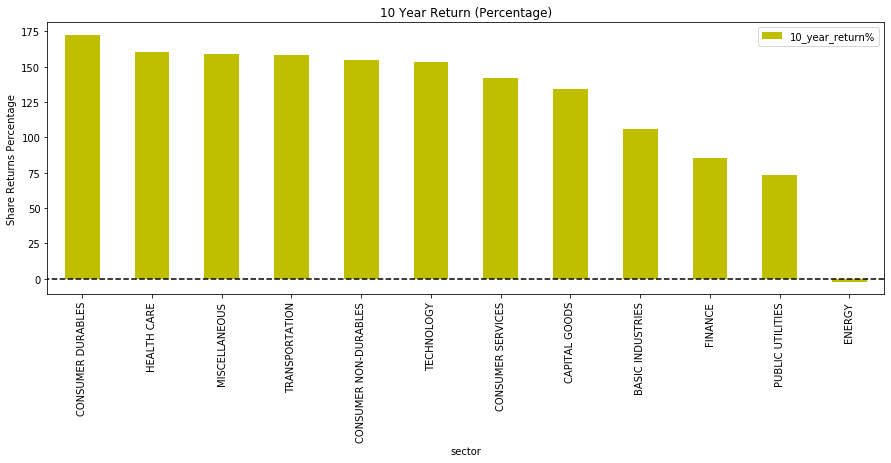

In [10]:
# 10 year return 
sector_ticker_price = df_cleaned_2000[['date', 'ticker', 'close', 'name', 'sector']]
sector_ticker_price = sector_ticker_price.set_index('ticker')
sector_ticker_price['2008_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2008-01-03']['close']
sector_ticker_price['2018_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close']
sector_ticker_price['10_year_return%'] = (sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close'] - sector_ticker_price.loc[sector_ticker_price['date'] == '2008-01-03']['close'])/sector_ticker_price.loc[sector_ticker_price['date'] == '2008-01-03']['close']*100
sector_ticker_price_ten = sector_ticker_price[['name', 'sector', '10_year_return%']]
sector_ticker_price_ten.round(2).head(10)
ten_year_groupby_sector=sector_ticker_price_ten.groupby("sector")
ten_year_avg_change_by_sector=ten_year_groupby_sector.mean()
ten_year_avg_change_by_sector = ten_year_avg_change_by_sector.sort_values('10_year_return%',ascending=False)
ten_year_avg_change_by_sector.round(2)
ten_year_avg_change_by_sector.plot.bar(color="y",title="10 Year Return (Percentage)", figsize=[15,5])
plt.ylabel('Share Returns Percentage')
plt.hlines(0, -1, 12, linestyles='dashed');
plt.savefig("Ten_year_return%")

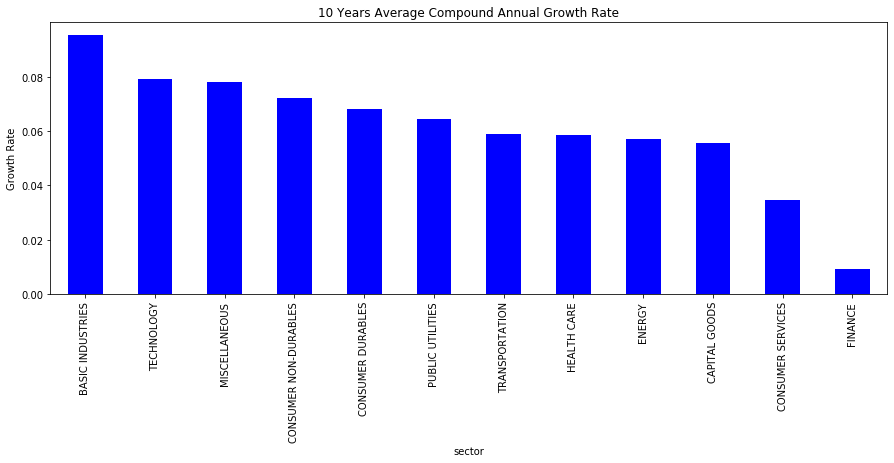

In [11]:
# 10 year CAGR
CAGR_10_mean=CAGR_mean.sort_values('CAGR_10year',ascending=False)
Avg_10yr_CAGR_chart=CAGR_10_mean['CAGR_10year'].plot(kind="bar",figsize=[15,5],color='blue',title="10 Years Average Compound Annual Growth Rate")
plt.ylabel('Growth Rate');
plt.savefig('Ten_year_CAGR')


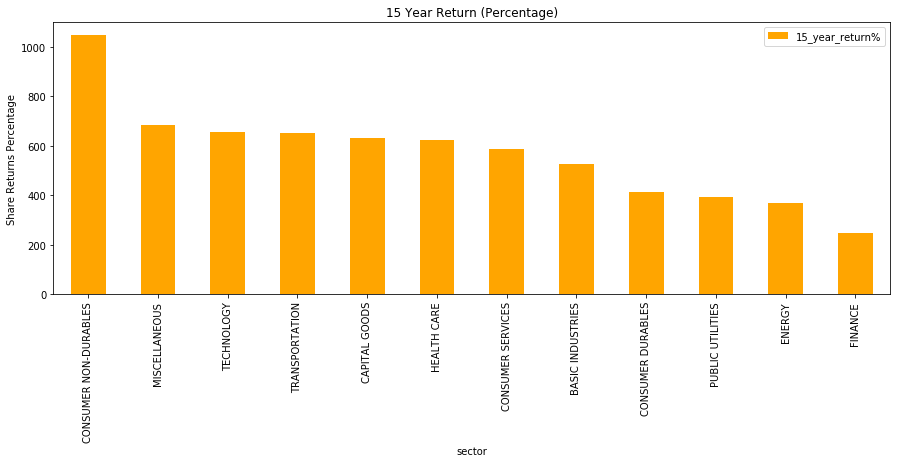

In [12]:
# 15 Year Return
sector_ticker_price = df_cleaned_2000[['date', 'ticker', 'close', 'name', 'sector']]
sector_ticker_price = sector_ticker_price.set_index('ticker')
sector_ticker_price['2003_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2003-01-03']['close']
sector_ticker_price['2018_close'] = sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close']
sector_ticker_price['15_year_return%'] = (sector_ticker_price.loc[sector_ticker_price['date'] == '2018-01-04']['close'] - sector_ticker_price.loc[sector_ticker_price['date'] == '2003-01-03']['close'])/sector_ticker_price.loc[sector_ticker_price['date'] == '2003-01-03']['close']*100
sector_ticker_price_fifteen = sector_ticker_price[['name', 'sector', '15_year_return%']]
sector_ticker_price_fifteen.head(10)
fifteen_year_groupby_sector=sector_ticker_price_fifteen.groupby("sector")
fifteen_year_avg_change_by_sector=fifteen_year_groupby_sector.mean()
fifteen_year_avg_change_by_sector=fifteen_year_avg_change_by_sector.sort_values('15_year_return%', ascending=False)
fifteen_year_avg_change_by_sector.round(2)
fifteen_year_avg_change_by_sector.plot.bar(color="orange",title="15 Year Return (Percentage)", figsize=[15,5])
plt.ylabel('Share Returns Percentage');
plt.savefig("Fifteen_year_return%")

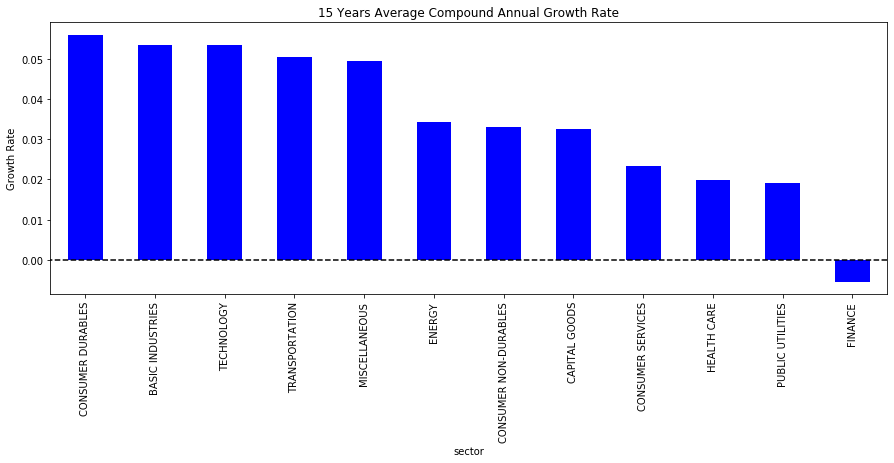

In [13]:
# 15 year CAGR
CAGR_15_mean=CAGR_mean.sort_values('CAGR_15year',ascending=False)
Avg_10yr_CAGR_chart=CAGR_15_mean['CAGR_15year'].plot(kind="bar",figsize=[15,5],color='blue',title="15 Years Average Compound Annual Growth Rate")
plt.ylabel('Growth Rate');
plt.hlines(0,-1,12,linestyles='dashed')
plt.savefig('Fifteen_year_CAGR')

please input a tickerAMZN
AMZN
enter another ticker for comparisonAAPL
AAPL


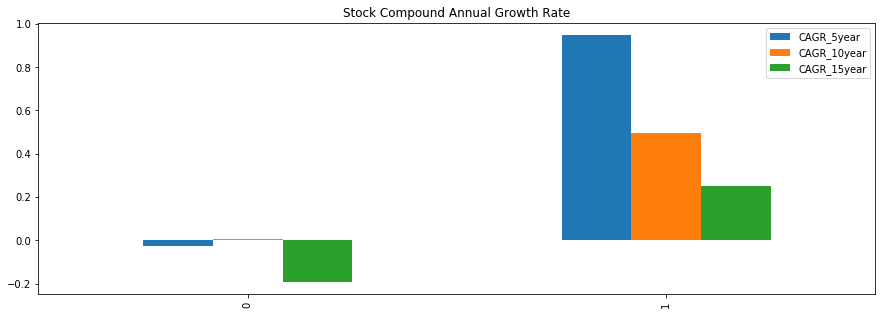

In [14]:
ticker_name = input('please input a ticker')
print(ticker_name)

cagr_values_for_firstticker = all_stock_prices.loc[all_stock_prices['ticker']==ticker_name][['ticker','CAGR_5year','CAGR_10year','CAGR_15year']]
ticker_name = input('enter another ticker for comparison')
print(ticker_name)

cagr_values_for_secondticker = all_stock_prices.loc[all_stock_prices['ticker']==ticker_name][['ticker','CAGR_5year','CAGR_10year','CAGR_15year']]
individual_stock_cagr_comparison  = cagr_values_for_firstticker.append(cagr_values_for_secondticker, ignore_index=True)
individual_stock_cagr_comparison.set_index('ticker')
stock_CAGR_Comparison_chart=individual_stock_cagr_comparison.plot(kind="bar",figsize=[15,5],title="Stock Compound Annual Growth Rate")


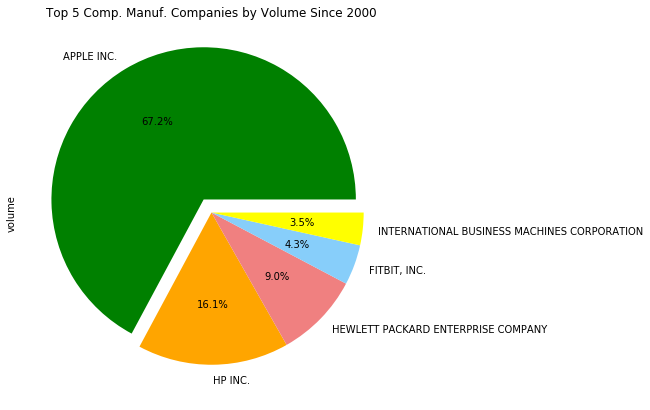

In [15]:
#Look into Tech Sector and identify the industry with highest trading volume
tech_sector_df=df_cleaned_2000.loc[(df_cleaned_2000['sector'] == 'TECHNOLOGY')]
groupby_industry=tech_sector_df.groupby("industry")
groupby_industry=groupby_industry["volume"].mean()
groupby_industry_df=pd.DataFrame(groupby_industry)
groupby_industry_sort=groupby_industry_df.sort_values(by=["volume"],ascending=False)
groupby_industry_sort.reset_index()

#Creating a new data frame tha shows 10 year price change for all the companies in Technology sector
tech_extracted= tech_sector_df[['date', 'ticker', 'close', 'name',"industry"]]
tech_extracted = tech_extracted.set_index('ticker')
tech_extracted['2008_close'] = tech_extracted.loc[tech_extracted['date'] == '2008-01-03']['close']
tech_extracted['2018_close'] = tech_extracted.loc[tech_extracted['date'] == '2018-01-04']['close']
tech_extracted['10_year_change%'] = (tech_extracted.loc[tech_extracted['date'] == '2018-01-04']['close'] - tech_extracted.loc[tech_extracted['date'] == '2008-01-03']['close'])/tech_extracted.loc[tech_extracted['date'] == '2003-01-03']['close']*100
tech_extracted_ten = tech_extracted[['name', 'industry','10_year_change%']]
tech_extracted_ten.head()

#Find out which industry within technology sector has most 10 year return from 2008 to 2018.
tech_sector_ten=tech_extracted.groupby("industry")
tech_sector_ten=tech_sector_ten.mean()
tech_sector_ten.sort_values(by=["10_year_change%"],ascending=False).reset_index()

#To find out which company in "Computer Manufacturing" industry has highest trading volume.
comp_manuf=tech_sector_df.loc[(tech_sector_df['industry'] == 'COMPUTER MANUFACTURING')]
company_name=comp_manuf.groupby(["name"])
company_name=company_name["volume"].mean()
company_name_df=pd.DataFrame(company_name)
company_name_df=company_name_df.sort_values(by=["volume"],ascending=False)

#Extracting the top five companies that have highest trading volumes. 
top_five=company_name_df.iloc[0:5,:]
sizes = [220, 95, 80, 100]
colors = ["green", "orange", "lightcoral", "lightskyblue", 'yellow']
explode = (0.1, 0, 0, 0, 0)
top_five_pie=top_five.plot.pie(y="volume",figsize=(15,7),
                                explode=explode, colors=colors, autopct="%1.1f%%", 
                               title="Top 5 Comp. Manuf. Companies by Volume Since 2000")
plt.legend().set_visible(False)
plt.savefig("Top five computer manufacturing companies")


In [16]:
# Now that we have an understanding of the most profitable sectors
# and industries over the past 5, 10, and 15 years, let's take a
# look at where the best performing companies are located, how this
# has changed from 2000 to 2018. The optimal companies to target for 
# consistent daily returns, and how the media can lend guidance on 
# stock purchas or sells. 

In [17]:
# Small Identify outliers based on average volume for year 2000
Q1_vol = df_cleaned_2000['volume'].quantile(0.25)
Q3_vol = df_cleaned_2000['volume'].quantile(0.75)
vol_IQR = Q3_vol - Q1_vol

#Filter rows where volume is considered a low outlier
df_2000_no_out = df_cleaned_2000.loc[df_cleaned_2000['volume'] > Q1_vol]
df_2000_no_out = df_2000_no_out.reset_index(drop=True)
del df_2000_no_out['level_0']

# Stock data beginning year 2000
df_cleaned_2000_boy = df_2000_no_out.loc[df_2000_no_out['date']=='2000-01-03']
df_cleaned_2000_boy = df_cleaned_2000_boy.reset_index()
del df_cleaned_2000_boy['index']

# Stock data end year 2000
df_cleaned_2000_eoy = df_2000_no_out.loc[df_2000_no_out['date']=='2000-12-29']
df_cleaned_2000_eoy = df_cleaned_2000_eoy.reset_index()
del df_cleaned_2000_eoy['index']

# Combine beginning of year and end of year data
full_year_2000 = pd.merge(df_cleaned_2000_boy, df_cleaned_2000_eoy, on=['ticker'], how='inner')
full_year_2000 = full_year_2000[['ticker', 'name_x', 'exchange_x', 'sector_x', 'industry_x', 'date_x', 'open_x', 'close_x', 'adj_close_x', 'volume_x', 'date_y',  'open_y', 'close_y', 'adj_close_y', 'volume_y']]
full_year_2000['yearly_value_change'] = full_year_2000['adj_close_y'] - full_year_2000['open_x']
full_year_2000 = full_year_2000[['ticker', 'name_x', 'yearly_value_change']]

# Best stocks in terms of per-share value from beginning of year to end of year
desc_2000_yearly_change = full_year_2000.sort_values(['yearly_value_change'],ascending=False)
pos_year_change_2000 = desc_2000_yearly_change[:100]
pos_year_change_2000 = pos_year_change_2000.reset_index(drop=False)
del pos_year_change_2000['index']

# Call the Yahoo! Finance API to obtain address for top 100 growth stocks
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-summary"

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapid_api_key
    }

coordinates = []

for ticker in pos_year_change_2000['ticker'].values:    
    try:
        querystring = {"region":"US","symbol":ticker}
        tick_response = requests.get(url, headers=headers, params=querystring).json()
        tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city']
    except:
        continue        
    try:
        address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['state']
        address = ','.join(address)
    except KeyError as e:
        if e.args[0] == 'state':
            address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['country']
            address = ','.join(address)
    
    # Call the Google GeoCode API to obtain coordinates for stock address
    target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={gkey}'
    geo_response = requests.get(target_url).json()
    city_lat = geo_response['results'][0]['geometry']['location']['lat']
    city_lng = geo_response['results'][0]['geometry']['location']['lng']
    city_tup = (city_lat, city_lng)
    coordinates.append(city_tup)
    
# Plot those coordinates on Google Maps with Heatmap overlay
figure_layout = {
    'width': '1500px',
    'height': '900px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'}
gmaps.configure(api_key=gkey)
fig_2000 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(coordinates, dissipating=False, max_intensity=3, point_radius=2)
fig_2000.add_layer(heat_layer)
fig_2000

Figure(layout=FigureLayout(height='420px'))

In [18]:
# Take a similar approach and visualize locations of the best growth
# stocks for 2018. Do we have a bias of the bay area being where all
# the money is at? 

In [19]:
#Dataframe for stocks from Aug 2017 - Aug 2018
df_cleaned_2018 = sorted_current_trading.loc[sorted_current_trading['date'] >= '2017-08-24']
df_cleaned_2018 = df_cleaned_2018.reset_index()
del df_cleaned_2018['index']
del df_cleaned_2018['level_0']
Q1_2018_vol = df_cleaned_2018['volume'].quantile(0.25)
df_2018_no_out = df_cleaned_2018.loc[df_cleaned_2018['volume'] > Q1_2018_vol]
df_2018_no_out = df_2018_no_out.reset_index(drop=True)

# Stock data beginning year Aug 2017
df_cleaned_2018_boy = df_2018_no_out.loc[df_2018_no_out['date']=='2017-08-24']
df_cleaned_2018_boy = df_cleaned_2018_boy.reset_index(drop=True)

# Stock data end year Aug 2018
df_cleaned_2018_eoy = df_2018_no_out.loc[df_2018_no_out['date']=='2018-08-24']
df_cleaned_2018_eoy = df_cleaned_2018_eoy.reset_index(drop=True)

# Beginning of 2017 year and end of 2018 year data
full_year_2018 = pd.merge(df_cleaned_2018_boy, df_cleaned_2018_eoy, on=['ticker'], how='inner')
full_year_2018 = full_year_2018[['ticker', 'name_x', 'exchange_x', 'sector_x', 'industry_x', 'date_x', 'open_x', 'close_x', 'adj_close_x', 'volume_x', 'date_y',  'open_y', 'close_y', 'adj_close_y', 'volume_y']]
full_year_2018['yearly_value_change'] = full_year_2018['adj_close_y'] - full_year_2018['open_x']
full_year_2018 = full_year_2018[['ticker', 'name_x', 'yearly_value_change']]

# Worst stocks in terms of per-share value from beginning of year to end of year
asc_2018_yearly_change = full_year_2018.sort_values(['yearly_value_change'])
neg_year_change_2018 = asc_2018_yearly_change[:100]
neg_year_change_2018 = neg_year_change_2018.reset_index(drop=False)
del neg_year_change_2018['index']

# Best stocks in terms of per-share value from beginning of year to end of year
desc_2018_yearly_change = full_year_2018.sort_values(['yearly_value_change'],ascending=False)
pos_year_change_2018 = desc_2018_yearly_change[:100]
pos_year_change_2018 = pos_year_change_2018.reset_index(drop=False)
del pos_year_change_2018['index']

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-summary"

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapid_api_key
    }

coordinates = []

for ticker in pos_year_change_2018['ticker'].values:    
    try:
        querystring = {"region":"US","symbol":ticker}
        tick_response = requests.get(url, headers=headers, params=querystring).json()
        tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city']
    except:
        continue        
    try:
        address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['state']
        address = ','.join(address)
    except KeyError as e:
        if e.args[0] == 'state':
            address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['country']
            address = ','.join(address)
    
    # Obtain coordinates for ticker address
    target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={gkey}'
    geo_response = requests.get(target_url).json()
    city_lat = geo_response['results'][0]['geometry']['location']['lat']
    city_lng = geo_response['results'][0]['geometry']['location']['lng']
    city_tup = (city_lat, city_lng)
    coordinates.append(city_tup)
    
figure_layout = {
    'width': '1500px',
    'height': '900px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'}
gmaps.configure(api_key=gkey)
fig_2018 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(coordinates, dissipating=False, max_intensity=3, point_radius=2)

fig_2018.add_layer(heat_layer)
fig_2018

Figure(layout=FigureLayout(height='420px'))

In [20]:
pos_year_change_2018

,ticker,name_x,yearly_value_change
0,AMZN,"AMAZON.COM, INC.",947.97
1,GOOGL,ALPHABET INC.,293.04
2,GOOG,ALPHABET INC.,291.99
3,AZO,"AUTOZONE, INC.",256.85
4,ABMD,"ABIOMED, INC.",227.72
5,CMG,"CHIPOTLE MEXICAN GRILL, INC.",219.14
6,ISRG,"INTUITIVE SURGICAL, INC.",212.53
7,GWW,"W.W. GRAINGER, INC.",203.27
8,ALGN,"ALIGN TECHNOLOGY, INC.",193.60
9,NFLX,"NETFLIX, INC.",188.96


Text(0, 0.5, 'Average Transaction Volume (Tens of Millions)')

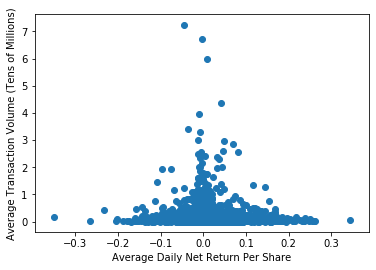

In [21]:
# Scatter plot of the Avg Volume per Day & Avg Share Return per Day
ticker_group = df_cleaned_2018.groupby('ticker')
avg_volume = ticker_group['volume'].mean()
avg_vol_df = pd.DataFrame(avg_volume).sort_values('volume', ascending=False)
avg_vol_df = avg_vol_df.reset_index()
avg_vol_df = avg_vol_df.rename(columns={'volume':'average_volume_2018'})

df_cleaned_2018['daily_net_return'] = df_cleaned_2018['close'] - df_cleaned_2018['open']
df_cleaned_2018 = df_cleaned_2018.loc[(df_cleaned_2018['daily_net_return'] < 2) & (df_cleaned_2018['daily_net_return'] > -2)]
daily_return_group = df_cleaned_2018.groupby('ticker')
daily_net_ret = daily_return_group['daily_net_return'].mean()
daily_net_ret_df = pd.DataFrame(daily_net_ret).sort_values('daily_net_return', ascending=False)
daily_net_ret_df = daily_net_ret_df.reset_index()

vol_return_2018 = pd.merge(avg_vol_df, daily_net_ret_df, on='ticker', how='inner')

plt.scatter(vol_return_2018['daily_net_return'], vol_return_2018['average_volume_2018'] / 10000000)
plt.xlabel('Average Daily Net Return Per Share')
plt.ylabel('Average Transaction Volume (Tens of Millions)')

In [22]:
# After removing outliers, is there a distribution between daily
# returns per share and stock transactions per day? 

top_500_net_ret = pd.DataFrame(daily_net_ret).sort_values('daily_net_return', ascending=False)[:500]
Q1_net_ret = top_500_net_ret['daily_net_return'].quantile(0.25)
Q3_net_ret = top_500_net_ret['daily_net_return'].quantile(0.75)
IQR_net_ret = Q3_net_ret - Q1_net_ret
clean_net_ret = top_500_net_ret.loc[(top_500_net_ret['daily_net_return'] > (Q1_net_ret - 1.5 * IQR_net_ret)) & (top_500_net_ret['daily_net_return'] < (Q3_net_ret + 1.5 * IQR_net_ret))]

top_500_avg_vol = pd.DataFrame(avg_volume).sort_values('volume', ascending=False)[:500]
Q1_avg_vol = top_500_avg_vol['volume'].quantile(0.25)
Q3_avg_vol = top_500_avg_vol['volume'].quantile(0.75)
IQR_avg_vol = Q3_avg_vol - Q1_avg_vol
clean_avg_vol = top_500_avg_vol.loc[(top_500_avg_vol['volume'] > (Q1_avg_vol - 1.5 * IQR_avg_vol)) & (top_500_avg_vol['volume'] < (Q3_avg_vol + 1.5 * IQR_avg_vol))]

clean_vol_return_2018 = pd.merge(clean_avg_vol, clean_net_ret, on='ticker', how='inner')
clean_vol_return_2018['volume'] = clean_vol_return_2018['volume'] / 1000000
clean_vol_return_2018 = clean_vol_return_2018.rename(columns={'volume': 'Average Transactions Per Day (Millions)',
                                     'daily_net_return': 'Average Daily Return (Dollars)'})

s
ge Daily Return (Dollars)'], kind="kde", color='blue');
plt.savefig('2018 Volume Per Day vs Per-Share Daily Returns')

SyntaxError: invalid syntax (<ipython-input-22-61ad8014419a>, line 22)

Please enter a US stock ticker: AMZN


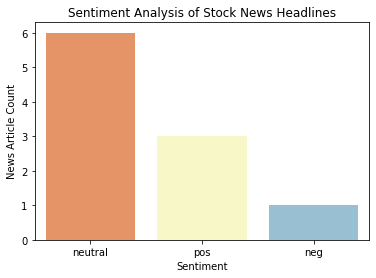

In [23]:
# Take a user-supplied stock-ticker, query sentiment analysis API
# with news headlines about the stock. Visualize the sentiment in
# a bar chart. 

news_url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-news"
user_stock = input('Please enter a US stock ticker: ')
news_querystring = {"region":"US","category":user_stock}
news_headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapid_api_key
    }
response = requests.get(news_url, headers=news_headers, params=news_querystring).json()

text_url = 'http://text-processing.com/api/sentiment/'

news_response = response['items']['result']

stock_classifications = []

for news in news_response:
    title = news['title']
    sentiment_data = {'text':title}
    sentiment_response = requests.post(url=text_url, data=sentiment_data).json()
    stock_classifications.append(sentiment_response['label'])
    
sns.countplot(x=stock_classifications, palette='RdYlBu')
plt.title('Sentiment Analysis of Stock News Headlines')
plt.xlabel('Sentiment')
plt.ylabel('News Article Count')
plt.savefig('Sentiment Bar Chart for Given Stock')